# 1. K-NN classifier

**Question** How does the k-nn algorithm work?

The k-Nearest Neighbors algorithm works by finding the k closest data points from the training set to a new input and assigning the class based on the majority vote among these neighbors.

**Question** What are the parameters we need to choose to classify with k-NN? How can we choose them

The parameters to choose for k-NN classification are the number of neighbors k, the distance metric (e.g., Euclidean, Manhattan), and optionally weighting of neighbors. These parameters can be chosen using cross-validation by selecting values that yield the best classification accuracy.

**Question** What are the advantages and disadvantages of this algorithm? For which kind of dataset it would be appropriate and for which datasets it wouldn't?

Advantages: simple, easy to understand, no explicit model building, effective on small and well-structured datasets.
Disadvantages: slow for large datasets, sensitive to noise and irrelevant features, the problem of the curse of dimensionality.
Suitable for small-medium sized, numerical datasets; unsuitable for very large or high-dimensional noisy datasets.

**Question** How can we deal with nominal values in distance measurement?

Nominal or categorical features can be handled by specialized distance measures designed for nominal data, such as the Value Difference Metric (VDM).



In further part of the laboratory, we will perform a preprocessing of the data and a classification of a set of biomedical voice measurements. Some of them has been recorded for people with Parkinson's desease.

More about the dataset: https://archive.ics.uci.edu/ml/datasets/parkinsons

First, we load the required packages:

In [27]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import numpy as np


# 2. Data loading and analysis of the attributes
Let's start with the data preparation, 
#### 2.1. Load the dataset from file parkinsons.csv into data frame using library pandas (pd.read_csv). Write the body of the read_data function to return a data frame with attributes and a list with class labels. Classes are available in 'status' column. You should also remove column 'name' from the data (see function drop of dataFrame https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html).

In [4]:
def read_data(path):
    import pandas as pd
    data = pd.read_csv(path)
    data_X = data.drop(columns=['name', 'status'])
    data_Y = data['status']
    return data_X, data_Y

data_X, data_Y = read_data("parkinsons.data")


Let's see what we have loaded.

In [10]:
data_X.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [11]:
data_Y

0      1
1      1
2      1
3      1
4      1
      ..
190    0
191    0
192    0
193    0
194    0
Name: status, Length: 195, dtype: int64

#### 1.2. Let's analyse the given data. 
* How many attributes are in given data? - 22
* Are the attributes on the common scale? - No
* Are observations equally distributed for sick and healthy people? - No

Plot the histogram of the assigned class and analyse the distribution.


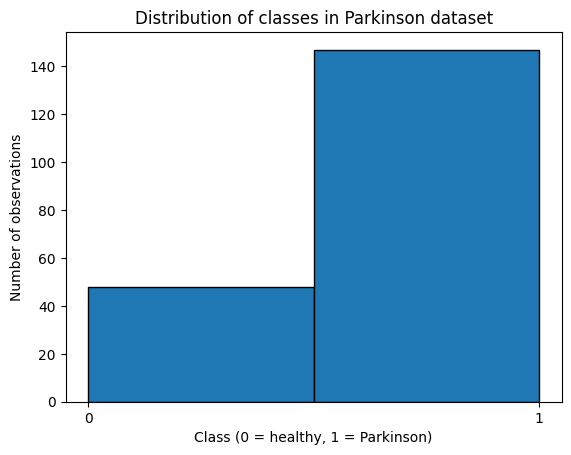

In [18]:
plt.hist(data_Y, bins=2, edgecolor='black')
plt.xlabel('Class (0 = healthy, 1 = Parkinson)')
plt.ylabel('Number of observations')
plt.title('Distribution of classes in Parkinson dataset')
plt.xticks([0, 1])
plt.show()

The histogram shows that data is imbalanced:
147 patients with Parkinson's disease (class 1)
48 healthy people (class 0)

Plot the histograms of the first 5 attributes. 

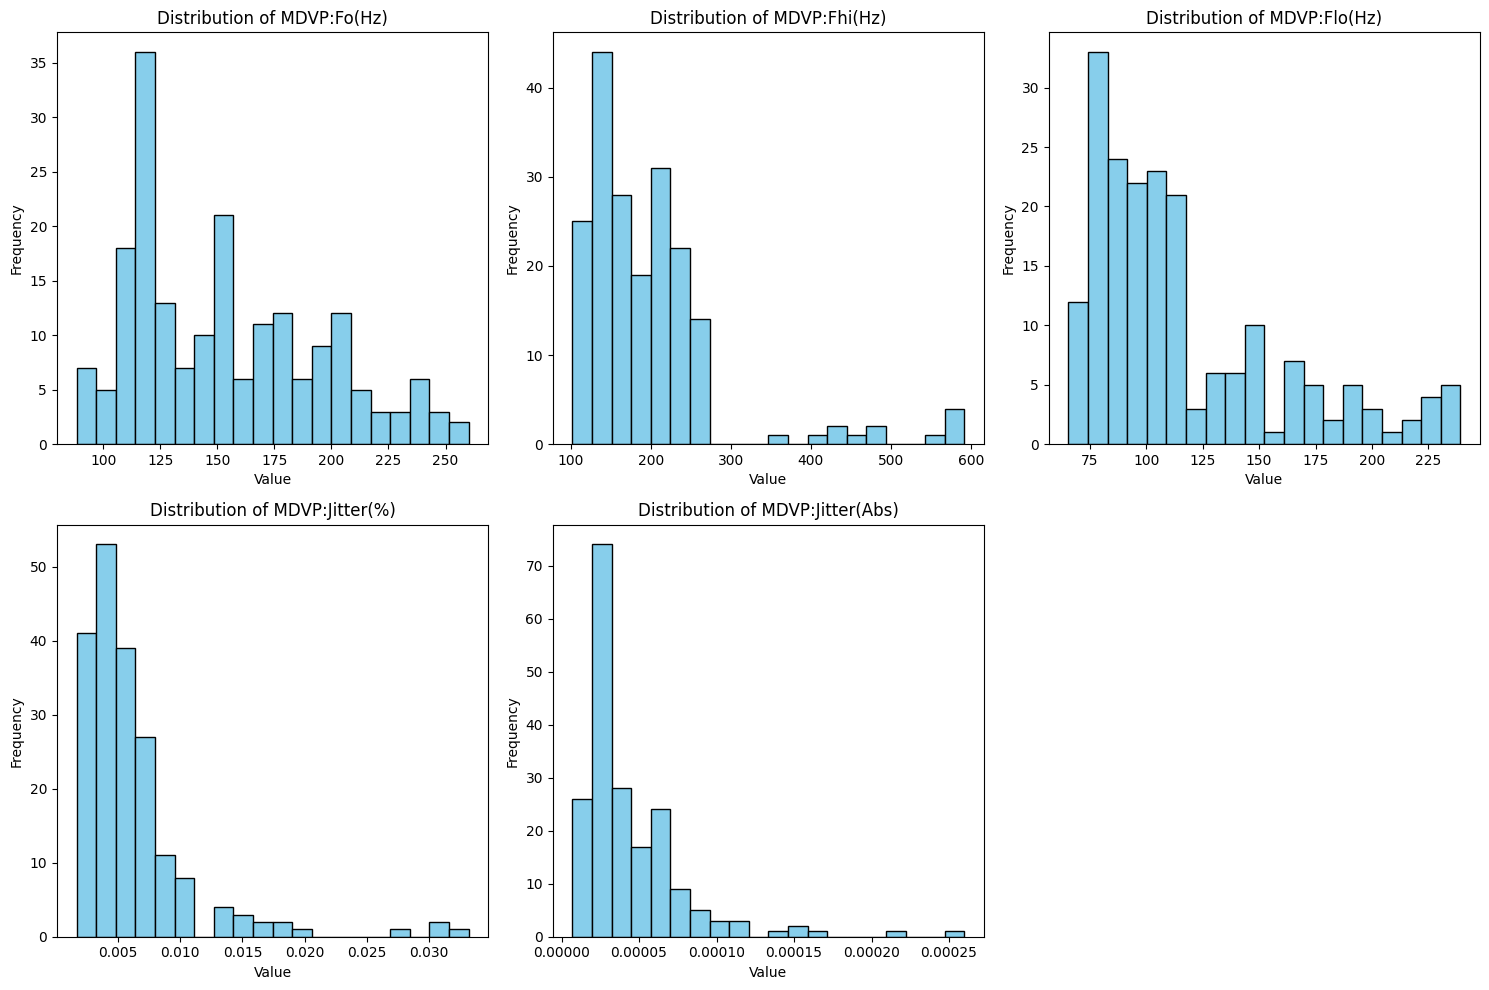

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

first_5_attributes = data_X.columns[:5]

for i, attr in enumerate(first_5_attributes):
    axes[i].hist(data_X[attr], bins=20, edgecolor='black', color='skyblue')
    axes[i].set_title(f'Distribution of {attr}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

axes[5].set_visible(False)

plt.tight_layout()
plt.show()


# 3. Train and test set selection

#### We want to build our classifier and test it on another set of observations.

To split data into train and test sets use train_test_split method from sklearn.model_selection module (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Use 80% of cases in train set and 20% in test set. 
Use random_state = 5 just to be sure we all have the same rows in train and test sets :)

split_data should return a tuple containing: dataframe with train set attributes, list of labels for train data, dataframe with test set attributes and a list of labels for test data.

In [20]:
def split_data(data_X, data_Y, test_percent=20, random_state=5):
    test_size = test_percent / 100
    train_X, test_X, train_Y, test_Y = train_test_split(
        data_X, 
        data_Y, 
        test_size=test_size, 
        random_state=random_state
    )    
    return train_X, train_Y, test_X, test_Y

(train_X, train_Y, test_X, test_Y) = split_data(data_X, data_Y)
print("rows in train set: ", train_X.shape[0])
print("rows in test set:", test_X.shape[0])

rows in train set:  156
rows in test set: 39


# 4. Data standarization/normalization
#### 4.1. Use k-nn algorithm to classify the obtained test set using k=3. What is the accuracy of the classification?

Use KNeighborsClassifier class from sklearn.neighbors module. Useful methods: fit and predict. Classification accuracy can be obtained with accuracy_score method from sklearn.metrics. Function get_classification_accuracy should return the accuracy of classification of given test set on model build with train set.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [23]:
def get_classification_accuracy(train_data_X, train_data_Y, test_data_X, test_data_Y, k=3):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_data_X, train_data_Y)    
    predictions = knn.predict(test_data_X)
    accuracy = accuracy_score(test_data_Y, predictions)
    return accuracy

result = get_classification_accuracy(train_X, train_Y, test_X, test_Y)
print(f"Accuracy with k=3: {result}")
print(f"Accuracy percentage: {result * 100:.2f}%")


Accuracy with k=3: 0.7692307692307693
Accuracy percentage: 76.92%


#### 4.2. Perform some normalization or standarization of attributes. Then repeat the classification. Do the classification accuracy change?

You can use sklearn.preprocessing.StandardScaler, sklearn.preprocessing.MinMaxScaler or sklearn.preprocessing.MaxAbsScaler and their fit_transform/transform methods.

Try other standarization methods to verify the standarization procedure influence the classification accuracy.
standarize_train_and_test should return 2 dataFrames - with normalized train and normalized test sets.

In [26]:
def standarize_train_and_test(train_X, test_X):
    scaler = StandardScaler()    
    train_X_normalized = scaler.fit_transform(train_X)
    test_X_normalized = scaler.transform(test_X)
    
    train_X_normalized = pd.DataFrame(
        train_X_normalized, 
        columns=train_X.columns
    )
    test_X_normalized = pd.DataFrame(
        test_X_normalized, 
        columns=test_X.columns
    )    
    return train_X_normalized, test_X_normalized

norm_train_X, norm_test_X = standarize_train_and_test(train_X, test_X)

accuracy_before = get_classification_accuracy(train_X, train_Y, test_X, test_Y)
accuracy_after = get_classification_accuracy(norm_train_X, train_Y, norm_test_X, test_Y)

print(f"Accuracy without normalization: {accuracy_before * 100:.2f}%")
print(f"Accuracy with normalization: {accuracy_after * 100:.2f}%")
print(f"Difference: {(accuracy_after - accuracy_before) * 100:.2f}%")


Accuracy without normalization: 76.92%
Accuracy with normalization: 97.44%
Difference: 20.51%


# 5. Choosing k value
Using obtained in previous exercices train set with normalization/standarization use k-nn algoritm using k from 1 to 20. Use 5-fold cross-validation within the train set to obtain the classification accuracy. Plot the obtained accuracy of the classification. Which k value seems to be the best for the given dataset?

See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html for more info about cross validation in sklearn.

k=1: mean CV accuracy = 0.9359
k=2: mean CV accuracy = 0.8657
k=3: mean CV accuracy = 0.8851
k=4: mean CV accuracy = 0.8853
k=5: mean CV accuracy = 0.8722
k=6: mean CV accuracy = 0.8786
k=7: mean CV accuracy = 0.8722
k=8: mean CV accuracy = 0.8657
k=9: mean CV accuracy = 0.8591
k=10: mean CV accuracy = 0.8591
k=11: mean CV accuracy = 0.8333
k=12: mean CV accuracy = 0.8395
k=13: mean CV accuracy = 0.8329
k=14: mean CV accuracy = 0.8587
k=15: mean CV accuracy = 0.8395
k=16: mean CV accuracy = 0.8524
k=17: mean CV accuracy = 0.8524
k=18: mean CV accuracy = 0.8524
k=19: mean CV accuracy = 0.8524
k=20: mean CV accuracy = 0.8524

Best k value: 1 with accuracy: 0.9359


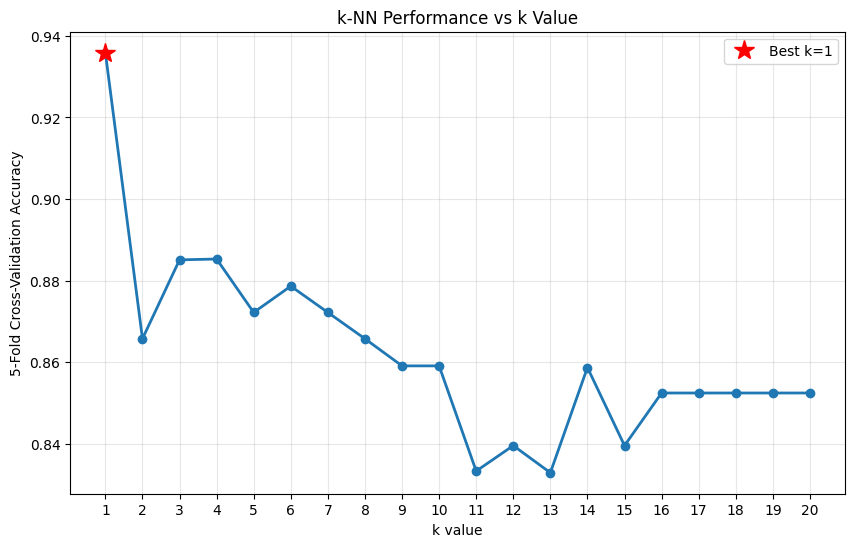

In [28]:
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(
        knn, 
        norm_train_X, 
        train_Y, 
        cv=5, 
        scoring='accuracy'
    )
    mean_score = cv_results['test_score'].mean()
    cv_scores.append(mean_score)    
    print(f"k={k}: mean CV accuracy = {mean_score:.4f}")

best_k = k_values[np.argmax(cv_scores)]
best_score = max(cv_scores)

print(f"\nBest k value: {best_k} with accuracy: {best_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('k value')
plt.ylabel('5-Fold Cross-Validation Accuracy')
plt.title('k-NN Performance vs k Value')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

plt.plot(best_k, best_score, 'r*', markersize=15, label=f'Best k={best_k}')
plt.legend()
plt.show()


# 6. Testing classifier
Train the k-NN classifier again and test it using the obtained best k value on a test set to check the final classification accuracy. You can just call the previous written function get_classification_accuracy)

In [30]:
best_k = 1

final_test_accuracy = get_classification_accuracy(
    norm_train_X, 
    train_Y, 
    norm_test_X, 
    test_Y, 
    k=best_k
)

print(f"5-Fold Cross-Validation Accuracy: {best_score:.4f} ({best_score*100:.2f}%)")
print(f"Test Set Accuracy: {final_test_accuracy:.4f} ({final_test_accuracy*100:.2f}%)")
print(f"Difference: {abs(best_score - final_test_accuracy):.4f}")

5-Fold Cross-Validation Accuracy: 0.9359 (93.59%)
Test Set Accuracy: 0.9744 (97.44%)
Difference: 0.0385


# 7. Homework
You are given a dataset containing information about 1600 red wines (winequality.csv) containing 11 attributes and assignment to one of the three wine quality classess: "poor", "medium" and "good". Perform a preprocessing of this dataset (normalization, standardization). Divide this set into the train and test sets. Choose experimentally the best value of k (using cross-validation) and perform classification using the  k-nn algoritm with the chosen k value. Write a report containing information about the used preprocessing methods, chosen train/test split method (percentage of examples in train/test sets, if shuffling or stratification used), plot of the accuracy depending of k parameter, finally chosen k and obtained classification accuracy on a test set.

**Deadline +2 weeks**
    
    

# Step 1: Load wine quality dataset

In [36]:
wine_data = pd.read_csv('winequality-red.csv')
print(f"Number of samples: {wine_data.shape[0]}")
print(f"Number of features: {wine_data.shape[1] - 1}")
print(wine_data.head())

Number of samples: 1599
Number of features: 11
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol quality  
0      9.4    poor

# Step 2: Data Analysis


Target variable distribution:
quality
good      217
medium    638
poor      744
Name: count, dtype: int64

Class distribution (%):
quality
good      13.570982
medium    39.899937
poor      46.529081
Name: proportion, dtype: float64


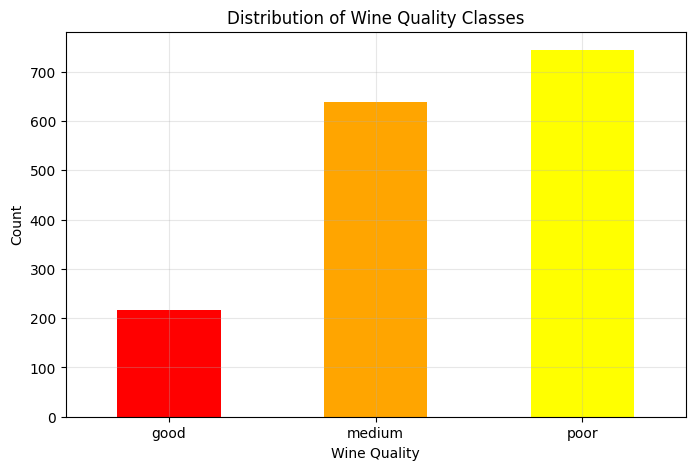

In [44]:
print(f"\nTarget variable distribution:")
print(wine_data['quality'].value_counts().sort_index())
print(f"\nClass distribution (%):")
print(wine_data['quality'].value_counts(normalize=True).sort_index() * 100)

wine_X = wine_data.drop('quality', axis=1)
wine_Y = wine_data['quality']

plt.figure(figsize=(8, 5))
wine_Y.value_counts().sort_index().plot(kind='bar', color=['red', 'orange', 'yellow'])
plt.xlabel('Wine Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality Classes')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()


# Step 3: Train-Test Split

In [45]:
wine_train_X, wine_test_X, wine_train_Y, wine_test_Y = train_test_split(
    wine_X, 
    wine_Y, 
    test_size=0.2, 
    random_state=5
)

print(f"Train set size: {wine_train_X.shape[0]}")
print(f"Test set size: {wine_test_X.shape[0]}")


Train set size: 1279
Test set size: 320


# Step 4: Normalization


In [46]:
scaler = StandardScaler()
wine_train_X_norm = scaler.fit_transform(wine_train_X)
wine_test_X_norm = scaler.transform(wine_test_X)

wine_train_X_norm = pd.DataFrame(wine_train_X_norm, columns=wine_train_X.columns)
wine_test_X_norm = pd.DataFrame(wine_test_X_norm, columns=wine_test_X.columns)

print("Normalization completed")

Normalization completed


# Step 5: Finding best k with cross-validation


k=1: accuracy = 0.6881
k=2: accuracy = 0.5942
k=3: accuracy = 0.5864
k=4: accuracy = 0.5755
k=5: accuracy = 0.5911
k=6: accuracy = 0.5911
k=7: accuracy = 0.5997
k=8: accuracy = 0.5997
k=9: accuracy = 0.6005
k=10: accuracy = 0.6005
k=11: accuracy = 0.6005
k=12: accuracy = 0.6052
k=13: accuracy = 0.6099
k=14: accuracy = 0.6169
k=15: accuracy = 0.6099
k=16: accuracy = 0.5919
k=17: accuracy = 0.6044
k=18: accuracy = 0.6044
k=19: accuracy = 0.6114
k=20: accuracy = 0.6067

Best k: 1


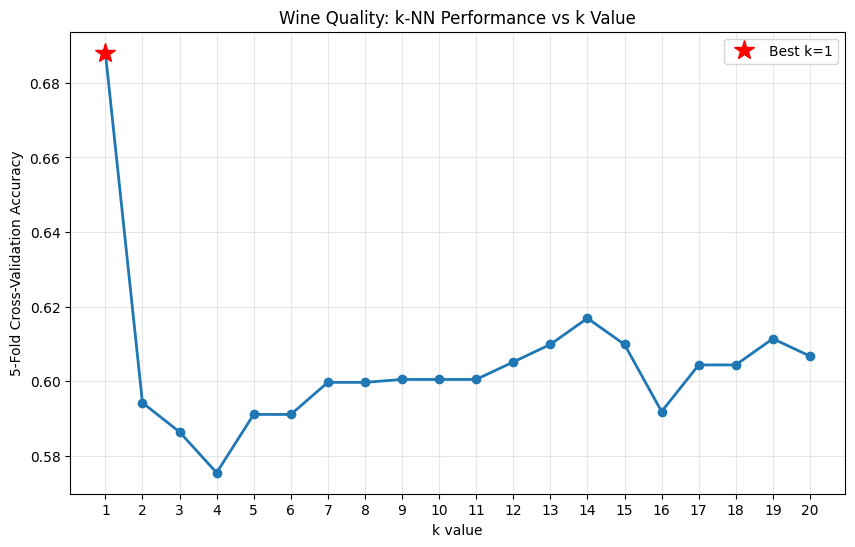

In [47]:
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn, wine_train_X_norm, wine_train_Y, cv=5, scoring='accuracy')
    mean_score = cv_results['test_score'].mean()
    cv_scores.append(mean_score)
    print(f"k={k}: accuracy = {mean_score:.4f}")

best_k = k_values[np.argmax(cv_scores)]
best_score = max(cv_scores)
print(f"\nBest k: {best_k}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('k value')
plt.ylabel('5-Fold Cross-Validation Accuracy')
plt.title('Wine Quality: k-NN Performance vs k Value')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.plot(best_k, best_score, 'r*', markersize=15, label=f'Best k={best_k}')
plt.legend()
plt.show()

# Step 6: Final testing with best k


In [48]:
final_accuracy = get_classification_accuracy(
    wine_train_X_norm, 
    wine_train_Y, 
    wine_test_X_norm, 
    wine_test_Y, 
    k=best_k
)

print(f"Best k: {best_k}")
print(f"Cross-Validation Accuracy: {best_score:.4f} ({best_score*100:.2f}%)")
print(f"Test Set Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")


Best k: 1
Cross-Validation Accuracy: 0.6881 (68.81%)
Test Set Accuracy: 0.6656 (66.56%)
